In [1]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (f1_score,
                             rand_score,
                             silhouette_score)
from itertools import product

In [2]:
X,y = make_blobs(n_samples=540, n_features=2, centers=3,cluster_std=2.1,random_state=420)
X[:,0] = X[:,0] * 2.75 + 170
X[:,1] = X[:,1] * 5 + 55

In [3]:
df = pd.DataFrame(data=X,columns=(['height','weight']))
df['Cluster'] = y

In [4]:
df[['height','weight']] = df[['height','weight']].round(4)

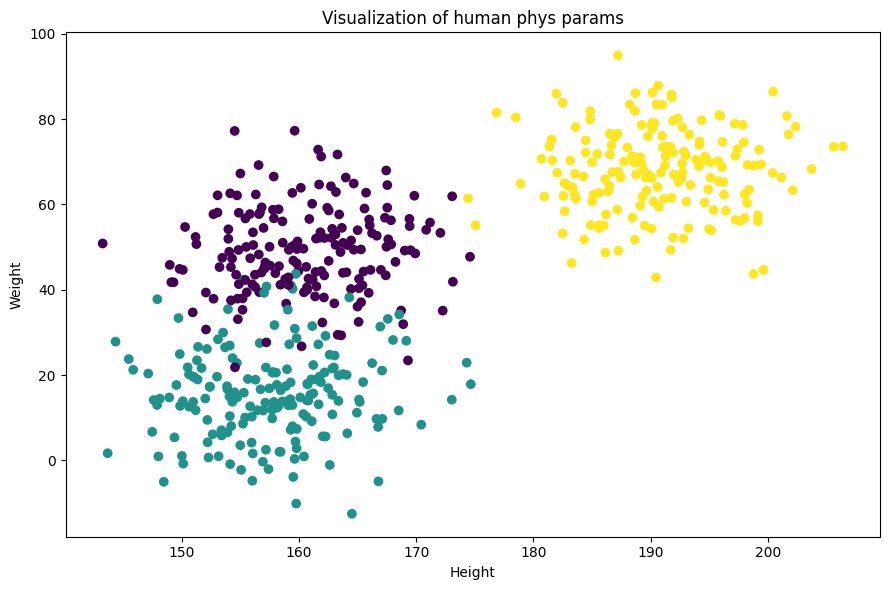

In [5]:
plt.figure(figsize=(9,6))
plt.scatter(df['height'],df['weight'],c=df['Cluster'])
plt.title('Visualization of human phys params')
plt.xlabel('Height')
plt.ylabel('Weight')
plt.tight_layout()

Основная идея:
1) Рандомно определяем центрианы:
2) Для каждой точки находим argmin от расстояния между центрианой и точкой, присваиваем метку кластера
3) Вычисляем центрианы заного, как среднее по кластеру

2 и 3 повторяем до момента, пока "движение" центрианы будет незначительным.

А задача заключается в минимизации суммы растояний (тут либо евклидово, либо манхеттенское расстояние)

In [6]:
class KMeans:

    def _initialize_centroids(self,X,k,method):
        features = X.columns[:-1] if 'pred' in X.columns else X.columns
        if method == 'random':
            return X[features].sample(k).values
        elif method == 'kmeans++':
            return self._kmeans_pp(X, k, features)

    def _kmeans_pp(self, X, k, features):
        centroids = []
        X_values = X[features].values
        
        # случайно выбираем первый центроид
        centroids.append(X_values[np.random.randint(0, len(X_values))])

        for _ in range(1, k):
            # для каждой точки находим минимальное расстояние до ближайшего центроида
            distances = np.array([min(np.linalg.norm(x - centroid)**2 for centroid in centroids) for x in X_values])

            # выбираем следующий центроид с вероятностью, пропорциональной квадрату расстояния
            probabilities = distances / distances.sum()
            cumulative_probabilities = np.cumsum(probabilities)
            r = np.random.rand()

            # выбираем следующий центроид на основе вероятности
            for i, p in enumerate(cumulative_probabilities):
                if r < p:
                    centroids.append(X_values[i])
                    break
        return np.array(centroids)

    def _distance(self,point,centroid,metric):
         # Проверка размерностей перед вычислением
        assert point.shape == centroid.shape, f"Shape mismatch 1: point {point}, centroid {centroid}"
        if metric == 'euclidean':
            return np.sqrt(np.sum((centroid-point)**2))
        elif metric == 'manhattan':
            return np.sum(np.abs((centroid-point)))
    def _assign_clusters(self,X,metric):
        '''
        Я прохожу по датафрейму всех точек, и получаю argmin по distance между центроидой(цикл for centriod in self.centroids) и точкой.
        '''
        features = X.columns[:-1] if 'pred' in X.columns else X.columns
        labels = np.zeros(len(X))  # Массив меток кластеров
        for i in range(len(X)):
            point = X.loc[i, features].values  # Используем все признаки
            distances = [self._distance(point, centroid, metric) for centroid in self.centroids]
            closest_centroid = np.argmin(distances)
            labels[i] = closest_centroid
        return labels

    def _recalculate_centroids(self,X,labels,k):
        new_centroids = []
        features = X.columns[:-1] if 'pred' in X.columns else X.columns  # Используем только признаки
        for i in range(k):
            cluster_points = X.loc[labels == i, features].values  # Точки, принадлежащие кластеру
            if len(cluster_points) == 0:
                new_centroids.append(self.centroids[i])
            else:
                new_centroid = cluster_points.mean(axis=0).round(4)
                new_centroids.append(new_centroid)
        return new_centroids

    def fit(self,X,k = 3,tol = 1e-4,method='random',metric = 'euclidean', max_iter=100, track_history= False,deep_history=False,vizualize=False):
        '''
        X: df с фичами
        k: к-во кластеров
        tol: условие сходимости
        method: метод инициализации центроид
        metric: метрика нахожления расстояния
        max_iter = максимальное кол-во итераций
        track_history: флаг на вывод подробностей
        deep_history: флаг на вывод подробных подробностей
        vizualize: флаг отрисовки
        Алгоритм:
        1.Инициализировать центроиды (с помощью _initialize_centroids).
        2.Назначать точки кластерам (через _assign_clusters).
        3.Пересчитывать центроиды (с помощью _recalculate_centroids).
        4.Повторять процесс до тех пор, пока не выполнится условие сходимости (допуск tol), или не будет достигнуто максимальное количество итераций.
        '''
        if deep_history:
            print(f'Инициализация для {k} кластеров')
        # X = X.drop(columns = ['Cluster'])
        self.count_iters = 0
        self.centroids = self._initialize_centroids(X,k,method)

        # Инициализация history перед началом цикла
        if vizualize:
            self.history = {'centroids': [self.centroids.copy()],'clusters':[]}  # Инициализация словаря history

        has_converged = False
        while not has_converged:
            labels = self._assign_clusters(X, metric)  # Получаем массив меток
            new_centroids = self._recalculate_centroids(X, labels, k)
            # Проверка размерностей перед сравнением центроидов
            assert np.array(new_centroids).shape == np.array(self.centroids).shape, \
                f"Разные размеры: new {np.array(new_centroids.shape)}, old {np.array(self.centroids.shape)}"

            has_converged = np.linalg.norm(np.array(new_centroids) - np.array(self.centroids)) < tol
            
            self.centroids = new_centroids

            if vizualize:
                self.history['centroids'].append(self.centroids.copy())
                self.history['clusters'].append(labels)    
            self.count_iters+=1
            if deep_history:
                print(f"Локальные центроиды: {self.centroids}")
            
            if self.count_iters >= max_iter:
                break
        if track_history:
            print(f'Алгоритм сошелся за {self.count_iters} итераций')
        if deep_history:
            print(f"Локальные кластеры: {set(labels)}")
            print(f"Локальные центроиды: {self.centroids}")
            
        # После завершения всех итераций присваиваем метки в DataFrame
        X['pred'] = labels
    
    def evaluate(self,X):
        inertia = self._inertia(X)
        return inertia

    def _inertia(self,X):
        inertia = 0
        for i in range(len(X)):
            point = X.loc[i, X.columns[:-1]].values  # Берем только признаки
            centroid = self.centroids[int(X.loc[i, 'pred'])]  # Центроид, к которому принадлежит точка
            # Проверка размерностей перед расчетом инерции
            assert point.shape == centroid.shape, f"Shape mismatch 2 : point {point.shape}, centroid {centroid.shape}"
            inertia += np.sum(np.linalg.norm(point - centroid) ** 2)
        return inertia
    
    def predict(self, X,metric):
        labels = self._assign_clusters(X, metric=metric)
        return labels

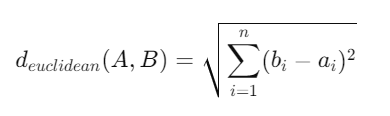
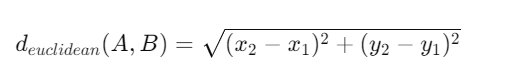

Данне уже сгенерированы, сейчас мы смоделируем ситуацию, когда мы видим даныне впервые и нужно понять, сколько кластеров. Будем использовать метод локтя

Инициализация для 2 кластеров
Локальные центроиды: [array([174.1196,  56.6133]), array([157.4786,  12.2632])]
Локальные центроиды: [array([177.0151,  60.49  ]), array([157.3886,  18.2493])]
Локальные центроиды: [array([179.8645,  63.4122]), array([157.8023,  22.7815])]
Локальные центроиды: [array([181.797,  64.882]), array([157.965 ,  25.0501])]
Локальные центроиды: [array([183.1688,  65.7062]), array([158.1141,  26.5282])]
Локальные центроиды: [array([184.2746,  66.2304]), array([158.1658,  27.5373])]
Локальные центроиды: [array([184.8929,  66.4902]), array([158.2142,  28.0925])]
Локальные центроиды: [array([185.27  ,  66.8489]), array([158.369 ,  28.4458])]
Локальные центроиды: [array([185.5259,  67.0393]), array([158.4447,  28.6751])]
Локальные центроиды: [array([185.6136,  67.1018]), array([158.469 ,  28.7519])]
Локальные центроиды: [array([185.6136,  67.1018]), array([158.469 ,  28.7519])]
Алгоритм сошелся за 11 итераций
Локальные кластеры: {0.0, 1.0}
Локальные центроиды: [array([

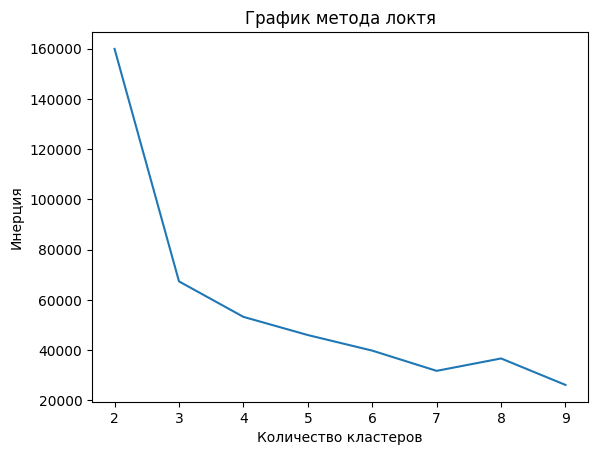

In [7]:
scores = []
KModel = KMeans()
X_f = df[['height', 'weight']].copy(deep=True)
rang = range(2, 10)
for k in rang:
    KModel.fit(X_f, k=k, metric='manhattan', max_iter=100, track_history=True,deep_history=True)
    scores.append(KModel.evaluate(X_f))
plt.title('График метода локтя')
plt.xlabel('Количество кластеров')
plt.ylabel('Инерция')
plt.plot(rang, scores)
plt.show()

Количество кластеров = 3(вау)

In [8]:
X_test =df[['height','weight']].copy(deep=True)

In [9]:
KMeanModel = KMeans()
KMeanModel.fit(X_test,k=3,method='kmeans++')

In [10]:
metr = KMeanModel.evaluate(X_test)
r_ind = rand_score(df['Cluster'],X_test['pred'])

In [11]:
print(F'Inertia: {metr}')
print(f"Индекс Ренда: {r_ind}")

Inertia: 67242.76904571
Индекс Ренда: 0.9460661032089603


In [12]:
params = {
    'metric':['euclidean','manhattan'],
    'method':['random','kmeans++'],
    'max_iter':[10,25,50,75,100],
    'tol':[1e-2,1e-3,1e-4,1e-5]
}

In [13]:
best_score = -1
best_params = []
all_scores = []
targ = df['Cluster'].copy(deep=True)

for metr,meth,ma,t in product(params['metric'],params['method'],params['max_iter'],params['tol']):
    df_copy = df[['height','weight']].copy(deep=True)
    KMeanModel = KMeans()
    KMeanModel.fit(df_copy, k = 3, metric = metr,method = meth, max_iter = ma,tol = t,vizualize=True)
    pred_labels = df_copy['pred']
    score = rand_score(targ,pred_labels)
    all_scores.append((score,{'metric':metr,'method':meth,'max_iter':ma,'tol':t}))
    if score > best_score:
        best_score = score
        best_params = {'metric':metr,'method':meth,'max_iter':ma,'tol':t}       
print(f'Параметры лучшей модели: {best_params},количество итераций {KMeanModel.count_iters} с индексом Рейнда {best_score}')

Параметры лучшей модели: {'metric': 'euclidean', 'method': 'random', 'max_iter': 10, 'tol': 0.01},количество итераций 6 с индексом Рейнда 0.9460661032089603


In [14]:
best_model = KMeans()
df_graph = df.copy(deep=True)

In [15]:
best_model.fit(df_graph,k=3,**best_params,vizualize=True)

In [16]:
best_model.evaluate(df_graph)

67269.77152351999

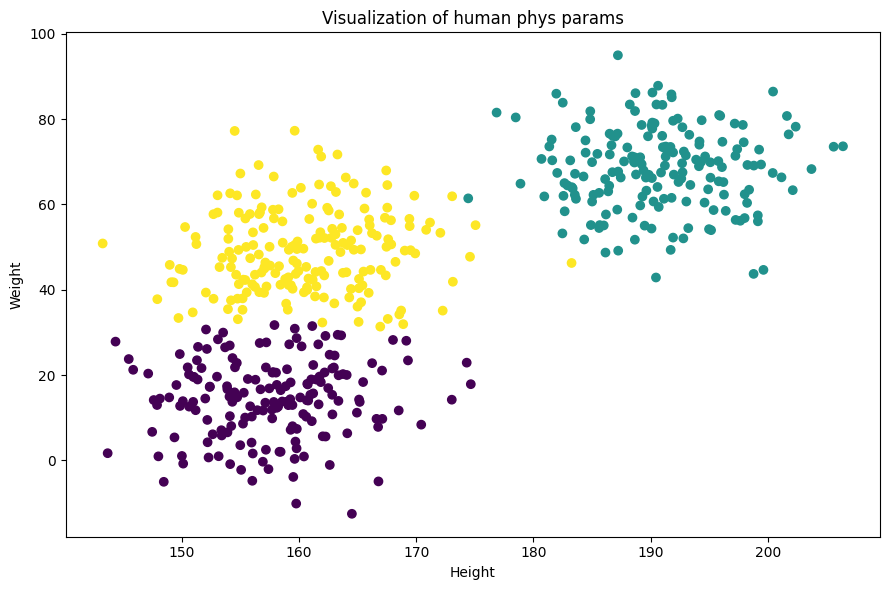

In [17]:
plt.figure(figsize=(9,6))
plt.scatter(df_graph['height'],df_graph['weight'],c = df_graph['pred'])
plt.title('Visualization of human phys params')
plt.xlabel('Height')
plt.ylabel('Weight')
plt.tight_layout()

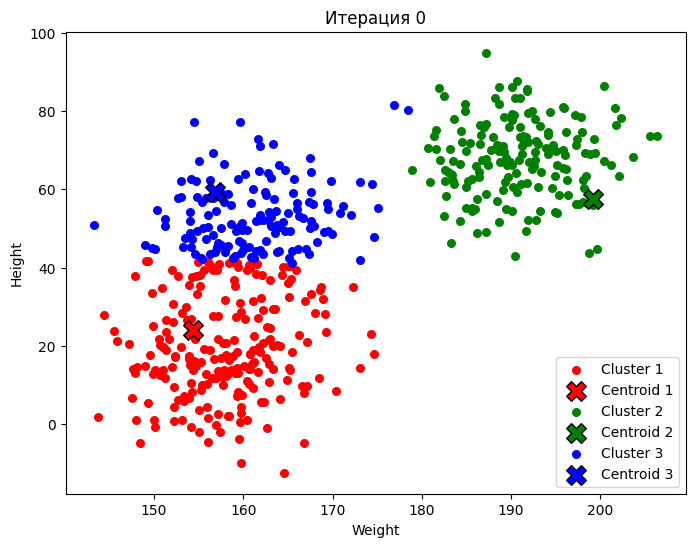

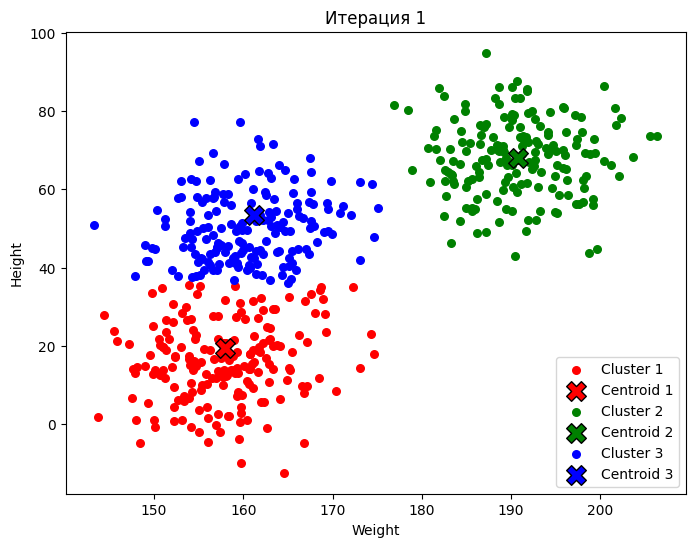

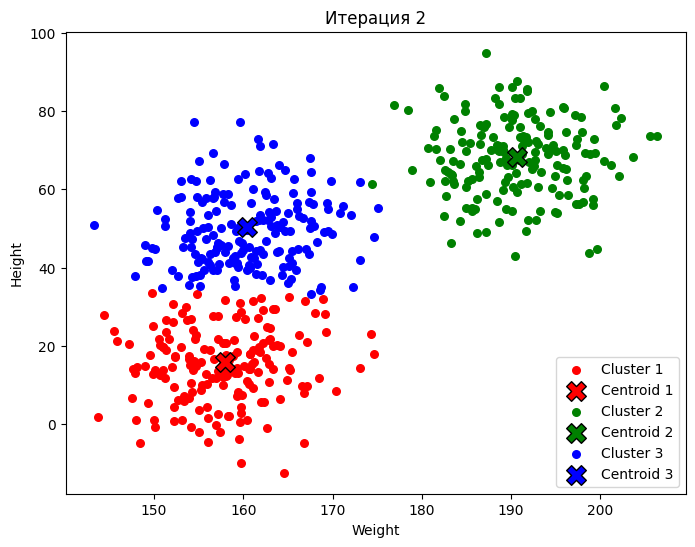

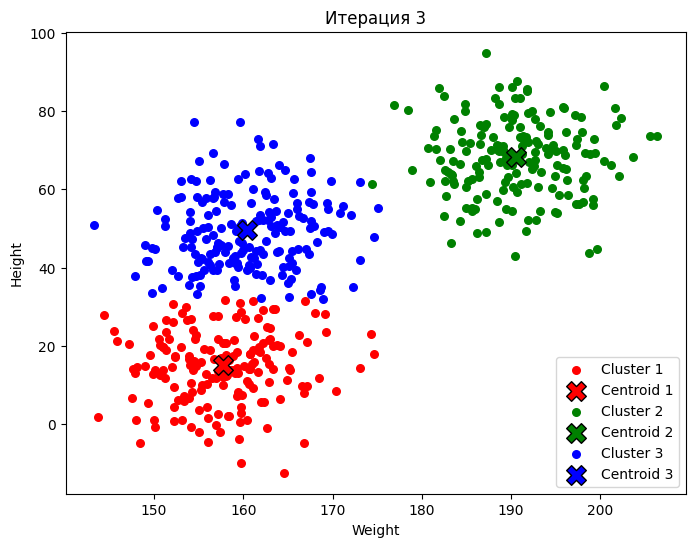

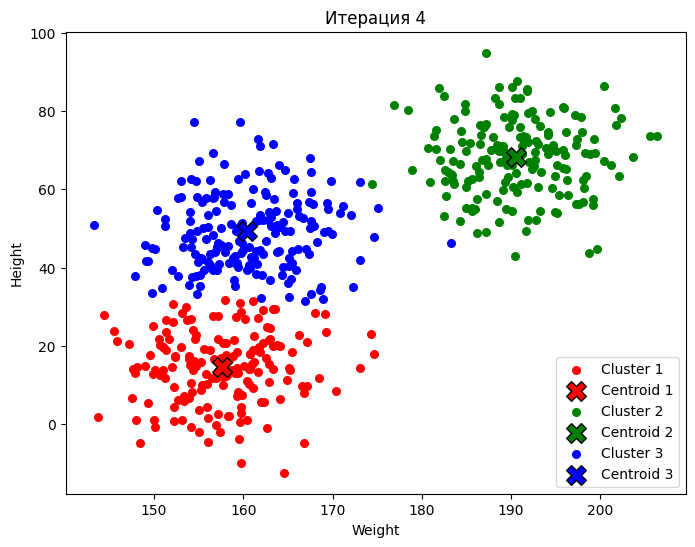

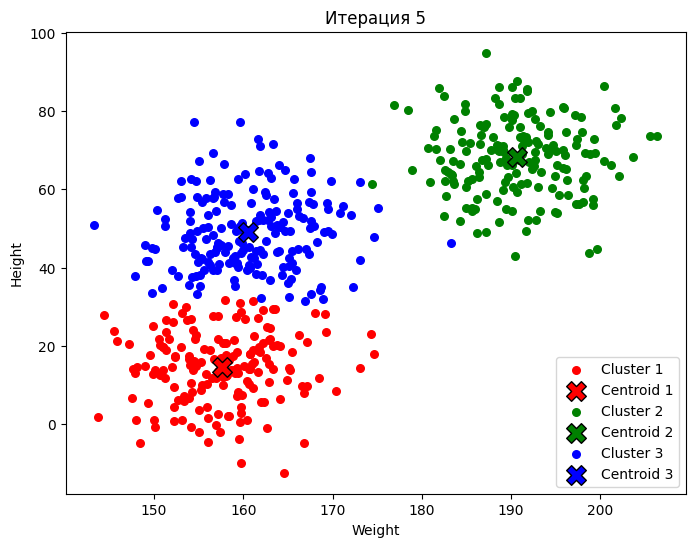

In [18]:
def visualize_kmeans(X, labels, centroids, iteration):
    plt.figure(figsize=(8, 6))
    colors = ['r', 'g', 'b', 'c', 'm', 'y']
    
    for i in range(len(centroids)):
        points = X.loc[labels == i].values
        plt.scatter(points[:, 0], points[:, 1], s=30, color=colors[i % len(colors)], label=f"Cluster {i+1}")
        plt.scatter(centroids[i][0], centroids[i][1], s=200, color=colors[i % len(colors)], marker='X', edgecolor='black', label=f"Centroid {i+1}")
    
    plt.title(f"Итерация {iteration}")
    plt.xlabel("Weight")
    plt.ylabel("Height")
    plt.legend()
    plt.show()

for i, (centroids,labels) in enumerate(zip(best_model.history['centroids'],best_model.history['clusters'])):
    visualize_kmeans(df_graph[['height', 'weight']], labels, centroids, i)